In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops     
import time
import random
from mini_batch import random_mini_batches
np.random.seed(1)

In [12]:
X = np.loadtxt('data.csv', delimiter = ',')
Y = np.loadtxt('label_mx10.csv', delimiter = ',')
Yr = np.loadtxt('label.csv', delimiter = ',')

X = X[0:3000, :]
Y = Y[0:3000, 0:3]

X = X.reshape(X.shape[0], 28, 28, 1)

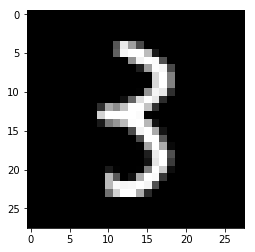

In [3]:
index = random.randrange(X.shape[0])
plt.imshow(X[index, :].reshape(28,28), cmap = 'gray')
plt.show()

In [4]:
def create_placeholder(nH0, nW0, nC0, ny):
    X = tf.placeholder(tf.float32, [None, nH0, nW0, nC0], name = 'X')
    Y = tf.placeholder(tf.float32, [None, ny], name = 'Y')
    return X, Y

In [5]:
def initialize_parameters():
    W1 = tf.get_variable('W1', [4,4,1,32], initializer = tf.contrib.layers.xavier_initializer(seed =0))
    W2 = tf.get_variable('W2', [5,5,32,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
       
    parameters = {
        'W1' : W1,
        'W2' : W2
    }
    return parameters

In [36]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'VALID')
    Z1n = tf.layers.batch_normalization(Z1, axis = 3)
    A1 = tf.nn.relu(Z1n)
    P1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'VALID')
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'VALID')
    Z2n = tf.layers.batch_normalization(Z2, axis = 3)
    A2 = tf.nn.relu(Z2n)
    P2 = tf.nn.max_pool(A2, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'VALID')
    
    P3 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P3, 3, activation_fn = None)
    #Zout = tf.nn.sigmoid(Z3)     # this is decreasing the accuracy
     
    return Zout      # bn increases time a little bit but, also increases accuracy really well

In [37]:
def cost_function(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    return cost

In [38]:
def model(X_train, Y_train, Yr, learning_rate = 0.0001, num_epoch = 10, minibatch_size = 128):
    ops.reset_default_graph()
    (m, nH0, nW0, nC0) = X_train.shape
    ny = Y_train.shape[1]
    tf.set_random_seed(1)
    
    X, Y = create_placeholder(nH0, nW0, nC0, ny)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = cost_function(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    stime = time.time()
    cost_list = []
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epoch):
            epoch_cost = 0
            point = 0
            num_minibatches = int(m/minibatch_size)
            for mini in range(num_minibatches):
                mini_X = X_train[point:point+minibatch_size, :]
                mini_Y = Y_train[point:point+minibatch_size, :]
                point = point + minibatch_size

                _, mini_cost = sess.run([optimizer, cost], feed_dict = {X:mini_X, Y:mini_Y})
                
                epoch_cost += mini_cost/num_minibatches 
                
            cost_list.append(epoch_cost)
            if epoch % (num_epoch/5) == 0 :
                print("Cost after", epoch, "is",epoch_cost)
            
        etime = time.time()
        min_times = (etime - stime)/60
        print("Time taken is %.2f" %min_times)
        
        plt.plot(np.squeeze(cost_list))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
        
        return parameters, train_accuracy

Cost after 0 is 1.3033596634864806
Cost after 1 is 1.0428261041641236
Cost after 2 is 0.9920546770095824
Cost after 3 is 0.8824999213218688
Cost after 4 is 0.8713178277015685
Time taken is 1.60


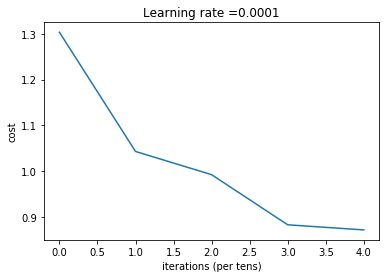

Train Accuracy: 0.6016667


In [39]:
p, zr = model(X, Y, Yr, learning_rate = 0.0001, num_epoch = 5, minibatch_size = 512)